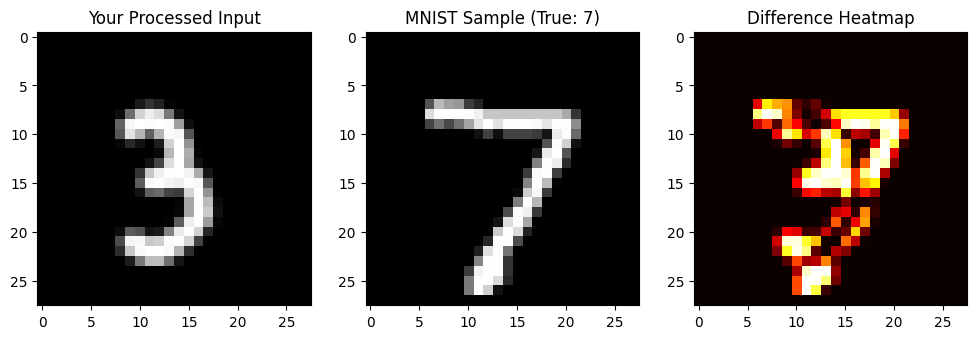

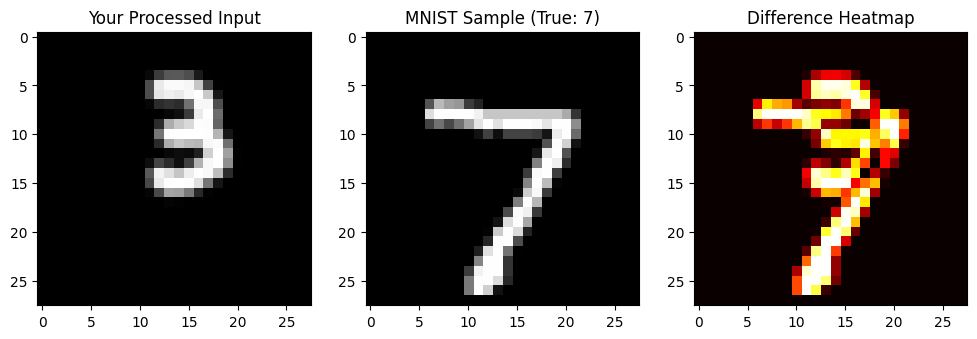

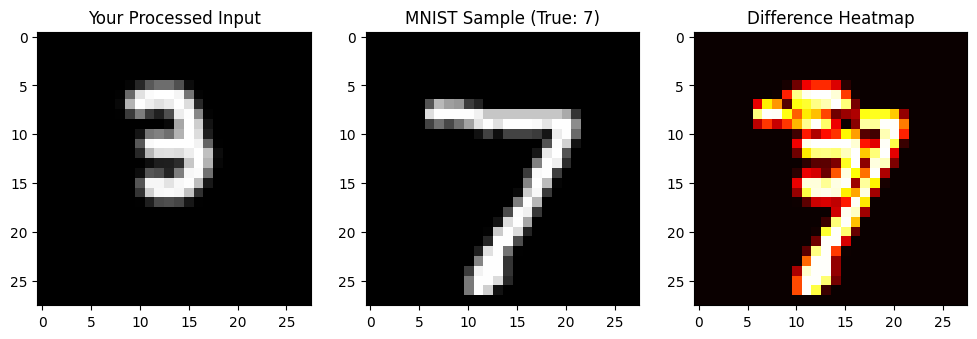

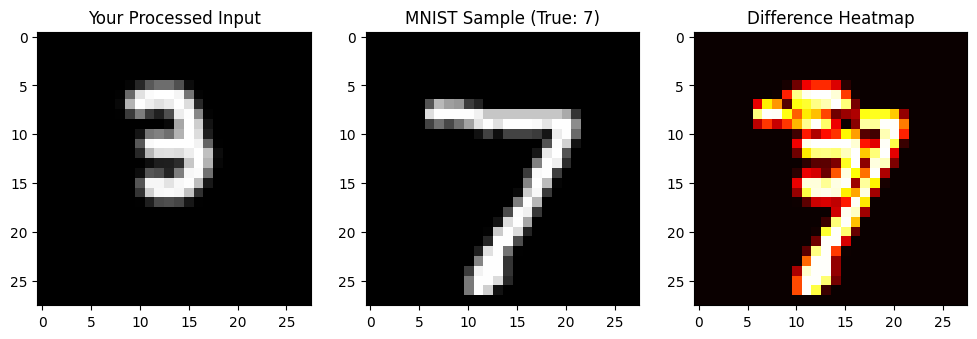

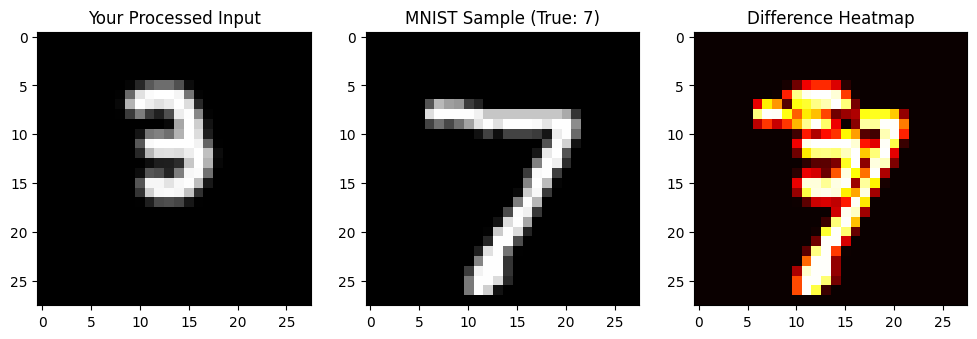

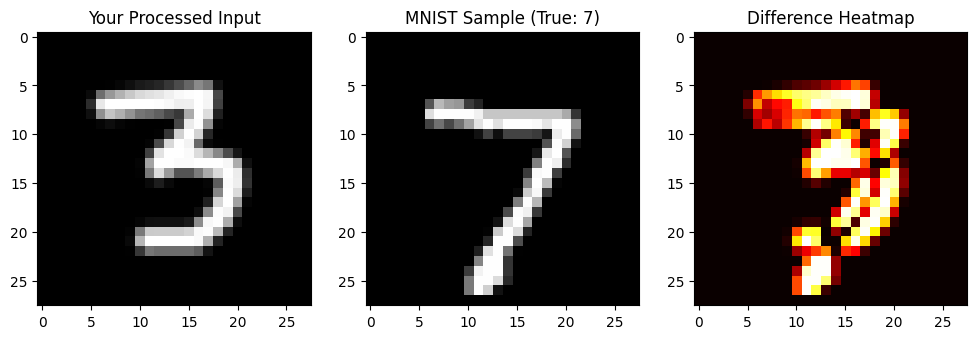

In [46]:
from ipycanvas import Canvas, hold_canvas
from ipywidgets import Button, VBox, HBox, Label
import numpy as np
from PIL import Image, ImageOps
import tensorflow as tf
import matplotlib.pyplot as plt

# Load MNIST-verified model
model = tf.keras.models.load_model('num_recognition.keras')

# Create MNIST-style canvas (white on black)
canvas = Canvas(width=140, height=140, sync_image_data=True)  # Smaller canvas for better centering
with hold_canvas(canvas):
    canvas.fill_style = '#000000'
    canvas.fill_rect(0, 0, 140, 140)
    canvas.fill_style = '#FFFFFF'  # Drawing color matches MNIST
canvas.layout.border = '2px solid white'

# UI elements
clear_btn = Button(description='Clear', button_style='warning')
predict_btn = Button(description='Predict', button_style='success')
output_label = Label("Draw WHITE digits on BLACK background")

# Drawing configuration
BRUSH_SIZE = 8  # Matches MNIST stroke width when scaled
is_drawing = False

def handle_mouse_down(x, y):
    global is_drawing
    is_drawing = True
    with hold_canvas(canvas):
        canvas.fill_circle(x, y, BRUSH_SIZE)

def handle_mouse_move(x, y):
    if is_drawing:
        with hold_canvas(canvas):
            canvas.fill_circle(x, y, BRUSH_SIZE)

def handle_mouse_up(x, y):
    global is_drawing
    is_drawing = False

canvas.on_mouse_down(handle_mouse_down)
canvas.on_mouse_move(handle_mouse_move)
canvas.on_mouse_up(handle_mouse_up)

def clear_canvas(b=None):
    with hold_canvas(canvas):
        canvas.fill_style = '#000000'
        canvas.fill_rect(0, 0, 140, 140)
        canvas.fill_style = '#FFFFFF'

clear_btn.on_click(clear_canvas)

def mnist_preprocess(pil_image):
    """Exact MNIST preprocessing pipeline"""
    # 1. Binarization (matches MNIST threshold)
    image = pil_image.point(lambda x: 255 if x > 30 else 0)
    
    # 2. Center digit using MNIST's bounding box technique
    image = ImageOps.invert(image)  # For bounding box detection
    bbox = image.getbbox()
    if bbox:
        image = image.crop(bbox)
    image = ImageOps.invert(image)  # Restore original colors
    
    # 3. Scale while maintaining aspect ratio
    width, height = image.size
    scale = 20 / max(width, height)  # MNIST max dimension = 20px
    image = image.resize(
        (int(width*scale), int(height*scale)), 
        Image.BILINEAR
    )
    
    # 4. Pad to 28x28 with centering
    new_img = Image.new('L', (28, 28), 0)
    new_img.paste(image, (
        (28 - image.width) // 2,
        (28 - image.height) // 2
    ))
    
    return new_img

def predict_digit(b):
    try:
        # 1. Capture raw data (RGB channels)
        data = canvas.get_image_data()[:, :, :3]
        
        # 2. Convert to MNIST-style grayscale
        gray = np.dot(data, [0.2989, 0.5870, 0.1140]).astype(np.uint8)
        pil_img = Image.fromarray(gray)
        
        # 3. Apply MNIST's exact preprocessing
        processed_img = mnist_preprocess(pil_img)
        
        # 4. Compare with actual MNIST sample
        (_, _), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
        mnist_sample = Image.fromarray(x_test[0]).convert('L')
        
        # 5. Visualization
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
        
        ax1.imshow(processed_img, cmap='gray', vmin=0, vmax=255)
        ax1.set_title("Your Processed Input")
        
        ax2.imshow(mnist_sample, cmap='gray', vmin=0, vmax=255)
        ax2.set_title(f"MNIST Sample (True: {y_test[0]})")
        
        # 6. Model input comparison
        arr = np.array(processed_img).reshape(28, 28).astype(np.float32) / 255.0
        mnist_arr = x_test[0].astype(np.float32) / 255.0
        
        ax3.imshow(np.abs(arr - mnist_arr), cmap='hot')
        ax3.set_title("Difference Heatmap")
        plt.show()

        # 7. Make predictions
        your_pred = model.predict(arr.reshape(1, 28, 28, 1), verbose=0)[0]
        mnist_pred = model.predict(mnist_arr.reshape(1, 28, 28, 1), verbose=0)[0]
        
        output_label.value = (
            f"Your Prediction: {np.argmax(your_pred)} ({np.max(your_pred):.1%})\n"
            f"MNIST Prediction: {np.argmax(mnist_pred)} ({np.max(mnist_pred):.1%})"
        )

    except Exception as e:
        output_label.value = f"Error: {str(e)}"

predict_btn.on_click(predict_digit)

VBox([canvas, HBox([clear_btn, predict_btn]), output_label])

In [ ]:
# In a separate cell
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
test_sample = x_test[0].reshape(1, 28, 28, 1) / 255.0
print("Model test prediction:", np.argmax(model.predict(test_sample)))
print("Actual label:", y_test[0])